# Use the sum of the mCpG values instead of the CpG unit profiles for each read

In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import time
import shap

import sklearn

# import shap


In [2]:
CGs_all_silenced = np.load("/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_LOW_high_K562_nCATS_20241226_numFWD1576_numRVS1339_padded_reads_LOW_high_K562_nCATS_20241226_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy")
    # "/home/michalula/code/epiCausality/epiCode/dimelo_v2_output/CG_142_units_combined_silenced_T_primerES_nCATS_numFWD5860_numRVS4229_padded_reads_silenced_T_primerES_nCATS_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-04.npy")

CGs_all_silenced, CGs_all_silenced.shape

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan,  1.],
        [nan, nan, nan, ..., nan, nan,  1.],
        [nan, nan, nan, ..., nan, nan,  1.]]),
 (2915, 142))

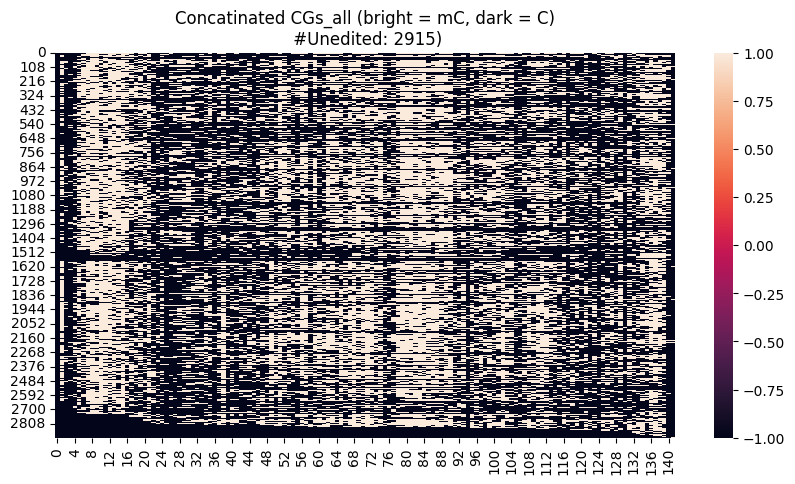

In [3]:
# plot X_unedited_silenced 

# Heatmap of CGs_all
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(CGs_all_silenced).fillna(-1))
plt.title(f"Concatinated CGs_all (bright = mC, dark = C)\n #Unedited: {CGs_all_silenced.shape[0]})")
plt.show()


In [4]:
CGs_all_unedited = np.load("/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_unedited_K562_R9P2_nCATS_2024927_numFWD240_numRVS57_padded_reads_unedited_K562_R9P2_nCATS_2024927_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy")
    # "/home/michalula/code/epiCausality/epiCode/dimelo_v2_output/CG_142_units_combined_unedited_T_primerES_nCATS_numFWD1940_numRVS1599_padded_reads_unedited_T_primerES_nCATS_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-04.npy")

CGs_all_unedited, CGs_all_unedited.shape

(array([[nan,  1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan,  1.]]),
 (297, 142))

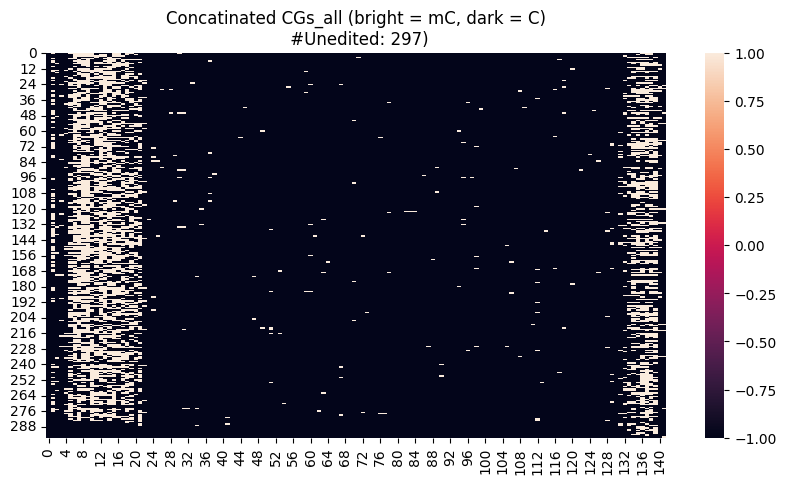

In [5]:
# plot X_unedited_silenced 

# Heatmap of CGs_all
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(CGs_all_unedited).fillna(-1))
plt.title(f"Concatinated CGs_all (bright = mC, dark = C)\n #Unedited: {CGs_all_unedited.shape[0]})")
plt.show()


In [6]:
# Assuming CGs_all_silenced is your NumPy array of shape 
num_rows = CGs_all_silenced.shape[0]  # Total number of rows
subset_size = CGs_all_unedited.shape[0] # 1743 # 1304  # Define how many rows you want to randomly select
print('subset_size = ', subset_size)

# Randomly select row indices
random_indices = np.random.choice(num_rows, subset_size, replace=False)

# Get the subset
subset = CGs_all_silenced[random_indices]

# Display the shape to confirm
print(subset.shape)  # Should be (subset_size, 10)

CGs_all_silenced = subset
CGs_all_silenced

subset_size =  297
(297, 142)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  1., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1., nan],
       [nan,  1., nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  1.,  1., nan]])

In [7]:
X_unedited_silenced = np.concatenate((CGs_all_unedited, CGs_all_silenced), axis=0)
X_unedited_silenced, X_unedited_silenced.shape

(array([[nan,  1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  1.,  1., nan],
        [nan,  1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1.,  1., nan]]),
 (594, 142))

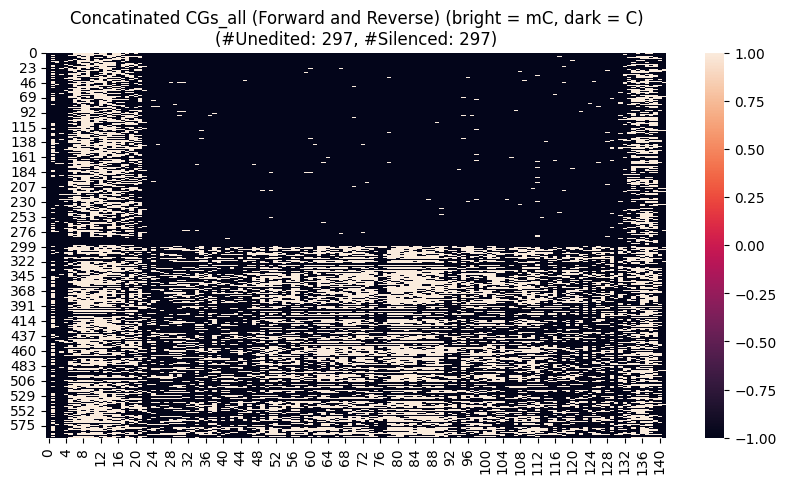

In [8]:
# plot X_unedited_silenced 

# Heatmap of CGs_all
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(X_unedited_silenced).fillna(-1))
plt.title(f"Concatinated CGs_all (Forward and Reverse) (bright = mC, dark = C)\n(#Unedited: {CGs_all_unedited.shape[0]}, #Silenced: {CGs_all_silenced.shape[0]})")
plt.show()


In [9]:
# Undetided cells nCATS get lable 0 as CD55 is lowly expressed in silened T cells (~90% of cells should be silenced)
y_silenced = np.array([0] * CGs_all_silenced.shape[0])
y_silenced, y_silenced.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
# Undetided T cells nCATS get lable 1 as CD55 is highly expressed in undetided T cells
y_unedited = np.array([1] * CGs_all_unedited.shape[0])
y_unedited, y_unedited.shape

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
y_unedited_silenced = np.concatenate((y_unedited, y_silenced), axis=0)
y_unedited_silenced, y_unedited_silenced.shape

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [12]:
train_idx, test_idx = train_test_split(np.arange(y_unedited_silenced.shape[0]), train_size=.75, random_state=16, shuffle=True)
train_idx, test_idx, len(train_idx), len(test_idx)

(array([416, 525,  25, 469, 213, 345, 399, 461, 307, 475, 457, 375, 481,
        200,  35, 408, 498, 548, 322, 119, 279,  20, 225, 529, 536, 189,
        202, 246, 273, 174, 587, 495, 567, 409, 423,  76,  92, 137, 149,
         38, 295, 559,  87, 142, 286, 253, 414, 112, 222,  70, 554, 128,
        499,   4,  46, 388,  93, 386, 523, 558,  51, 210, 241, 130, 126,
        304,  52,   9, 251, 124, 257, 591, 333, 263,  74,  55,  19, 420,
        521,  88, 172, 422, 303, 440, 546, 545, 167,  90, 326, 199, 129,
        478, 468, 460, 131, 204, 242, 539,  78,  71, 125, 156,  10, 522,
        425, 220, 288, 573, 274, 572, 486, 179, 456, 506, 212,  59, 284,
        377,  29, 191, 134, 435, 560, 474, 289,  67, 394, 472, 479, 102,
        426, 340, 515, 259, 412, 310,  12,   7, 400, 413, 361, 396, 276,
         79, 445, 373,  75, 163, 343, 320, 509, 398, 249, 139, 577, 576,
        237, 555, 194, 168, 231, 393, 300, 369,  56, 429,  43,  58, 405,
        219, 391,  33, 530, 154, 277, 260,  48, 181

In [13]:
X = pd.DataFrame(X_unedited_silenced).fillna(-1)
y = y_unedited_silenced

In [14]:
X.iloc[16:23,:]

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,141
16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
19,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
20,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
21,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
22,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [15]:
X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((445, 142), (149, 142), (445,), (149,))

In [16]:
def predict_reg(f, X, y):
    preds = f.predict(X)
    preds_round = np.round(preds) # / 50) # 100-->2; 50-->1; 0-->0
    # print('preds=', preds[:16])
    # print('preds_round', preds_round[:16])
    # print('np.mean(preds_round==y)*100 =', np.mean(preds_round==y)*100)
    # print('y', y[:16])
    # preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    # print('preds012', preds012[:16])
    # print('np.mean(preds012*50==y)*100 =', np.mean(preds012*50==y)*100)
    return np.mean(preds_round==y)*100

model = LinearRegression().fit(X_train,y_train)
print("GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = DecisionTreeRegressor().fit(X_train,y_train)
print("Tree: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = RandomForestRegressor().fit(X_train,y_train)
print("RF: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = GradientBoostingRegressor().fit(X_train,y_train)
print("GBM: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = MLPRegressor(max_iter=100,hidden_layer_sizes=(50,20)).fit(X_train, y_train)
print("NN: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = LogisticRegression(max_iter=1000, penalty="l1", solver='saga').fit(X_train,y_train)
print("Sparse GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

GLM: 83.89%
####
Tree: 81.88%
####
RF: 91.28%
####
GBM: 89.26%
####
NN: 86.58%
####


/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Sparse GLM: 91.95%


/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Use the SUM of the mCpG values instead of individual CpG unit profiles

# fill the empty values with 0 instead of -1

In [17]:
samples = pd.DataFrame(X_unedited_silenced).fillna(0)
# y = y_unedited_silenced
samples, samples.shape, np.unique(samples)

(     0    1    2    3    4    5    6    7    8    9    ...  132  133  134  \
 0    0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
 1    0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
 2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...  1.0  0.0  0.0   
 3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  1.0   
 4    0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  0.0  0.0  0.0   
 ..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 589  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
 590  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 591  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
 592  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
 593  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
 
      135  136  137  138  139  140  141  
 0    0.0  1.0  1.0 

In [18]:
samples[0]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
589    0.0
590    0.0
591    0.0
592    0.0
593    0.0
Name: 0, Length: 594, dtype: float64

In [19]:
# samples = np.array(X)

samples_sums = []
samples_sums = np.array([sum(s) for s in np.array(samples)])
samples_sums

array([15., 14., 12., 10., 10., 14., 10., 16., 19., 11.,  9.,  7., 13.,
       10., 20.,  9., 10.,  7., 18., 16.,  6., 17., 11., 18., 10., 15.,
       10., 18., 14., 15., 15., 15.,  9., 17., 11., 14., 15., 14., 17.,
        9., 10., 12., 11.,  9., 21.,  1., 18., 14., 14.,  7., 16.,  8.,
       13., 11., 18., 11., 17., 10., 18., 12., 11., 15.,  4., 13., 10.,
       16., 13., 17., 12., 17., 16., 19., 18., 14., 10., 10., 12.,  9.,
       11., 13., 20.,  7.,  8., 13., 15., 11.,  3.,  7., 17., 15., 11.,
        8., 14., 13., 16., 12., 16., 13., 10., 17., 17., 15., 15., 22.,
       19., 17.,  9., 15., 17., 18., 15., 15.,  9.,  6., 12., 15., 11.,
       12., 20., 13., 14.,  6., 14., 19., 12., 14., 15.,  9., 19., 12.,
       14., 15., 18., 16., 16., 22., 14., 22., 15., 11., 12., 22., 15.,
       18., 18., 16., 21., 20., 11., 11., 19., 13., 15.,  8., 20., 13.,
       23., 14., 11., 12., 13., 16., 18.,  1., 13., 10., 12., 19., 16.,
       20.,  8., 16., 12.,  8.,  9., 14., 19., 16., 13.,  7.,  8

In [20]:
samples.shape[1]

142

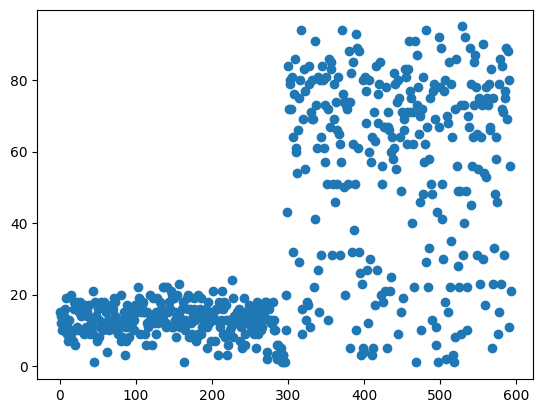

In [21]:
plt.scatter(np.arange(samples.shape[0]), samples_sums)

In [22]:
# pd.sammary(samples_sums)

/tmp/ipykernel_171343/1244085887.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


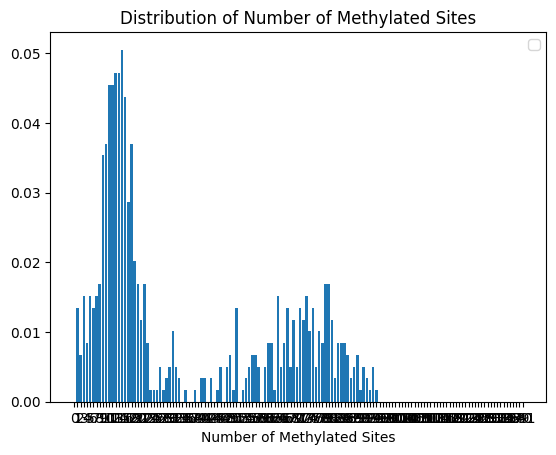

In [23]:
X_axis2 = np.arange(samples.shape[1])
# for i in range(3):
counts = [np.mean(np.round(samples_sums)==j) for j in range(samples.shape[1])]
plt.bar(X_axis2, counts) #, .25,label=celltypes[i])
plt.legend()
plt.title("Distribution of Number of Methylated Sites")
plt.xlabel("Number of Methylated Sites")
plt.xticks(X_axis2)
plt.show()


In [24]:
samples_sums.shape

(594,)

In [25]:
X = pd.DataFrame(samples_sums.reshape(samples_sums.shape[0],1)) #pd.DataFrame(samples_sums) #.fillna(-1)
y = y_unedited_silenced
X, y

(        0
 0    15.0
 1    14.0
 2    12.0
 3    10.0
 4    10.0
 ..    ...
 589  88.0
 590  11.0
 591  80.0
 592  56.0
 593  21.0
 
 [594 rows x 1 columns],
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1

In [26]:
X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((445, 1), (149, 1), (445,), (149,))

In [27]:
def predict_reg(f, X, y):
    preds = f.predict(X)
    preds_round = np.round(preds) # / 50) # 100-->2; 50-->1; 0-->0
    # print('preds=', preds[:16])
    # print('preds_round', preds_round[:16])
    # print('np.mean(preds_round==y)*100 =', np.mean(preds_round==y)*100)
    # print('y', y[:16])
    # preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    # print('preds012', preds012[:16])
    # print('np.mean(preds012*50==y)*100 =', np.mean(preds012*50==y)*100)
    return np.mean(preds_round==y)*100

model = LinearRegression().fit(X_train,y_train)
print("GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = DecisionTreeRegressor().fit(X_train,y_train)
print("Tree: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = RandomForestRegressor().fit(X_train,y_train)
print("RF: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = GradientBoostingRegressor().fit(X_train,y_train)
print("GBM: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = MLPRegressor(max_iter=100,hidden_layer_sizes=(50,20)).fit(X_train, y_train)
print("NN: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = LogisticRegression(max_iter=1000, penalty="l1", solver='saga').fit(X_train,y_train)
print("Sparse GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

GLM: 85.91%
####
Tree: 89.93%
####
RF: 89.93%
####
GBM: 89.93%
####
NN: 87.25%
####
Sparse GLM: 88.59%


/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


>> When using all 142 CpG units, the sum number sometimes improve the prediction scores

# Implement Cross Validation using sklearn
https://scikit-learn.org/stable/modules/cross_validation.html

from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())
scores['test_recall_macro']

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores

0.90 accuracy with a standard deviation of 0.01


array([0.89915966, 0.89915966, 0.90756303, 0.87394958, 0.90677966])

In [33]:
def predict_reg(f, X, y):
    ``
    # preds = f.predict(X)
    # preds_round = np.round(preds) # / 50) # 100-->2; 50-->1; 0-->0
    # # print('preds=', preds[:16])
    # # print('preds_round', preds_round[:16])
    # # print('np.mean(preds_round==y)*100 =', np.mean(preds_round==y)*100)
    # # print('y', y[:16])
    # # preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    # # print('preds012', preds012[:16])
    # # print('np.mean(preds012*50==y)*100 =', np.mean(preds012*50==y)*100)
    # return np.mean(preds_round==y)*100

    scores = cross_val_score(f, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    return scores.mean()*100




model = LinearRegression().fit(X_train,y_train)
print("GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = DecisionTreeRegressor().fit(X_train,y_train)
print("Tree: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = RandomForestRegressor().fit(X_train,y_train)
print("RF: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = GradientBoostingRegressor().fit(X_train,y_train)
print("GBM: {:.2f}%".format(predict_reg(model, X_test, y_test)))
print("####")
model = MLPRegressor(max_iter=100,hidden_layer_sizes=(50,20)).fit(X_train, y_train)
print("NN: {:.2f}%".format(predict_reg(model, X_test, y_test)))

print("####")
model = LogisticRegression(max_iter=1000, penalty="l1", solver='saga').fit(X_train,y_train)
print("Sparse GLM: {:.2f}%".format(predict_reg(model, X_test, y_test)))

0.53 accuracy with a standard deviation of 0.07
GLM: 52.53%
####
0.52 accuracy with a standard deviation of 0.11
Tree: 52.40%
####
0.58 accuracy with a standard deviation of 0.11
RF: 57.85%
####
0.53 accuracy with a standard deviation of 0.11
GBM: 53.25%
####
-2.64 accuracy with a standard deviation of 3.85
NN: -264.21%
####
0.89 accuracy with a standard deviation of 0.04
Sparse GLM: 88.55%


/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mi